# Initialise simulated data

In [1]:
import itertools

def generate_read_frame_distribution_permutations():
    """
    Generate all possible permutations of read frame distributions that sum to 100.
    
    Args:
        None

    Returns:
        simulated_read_frame_proportions (dict): Dictionary containing all possible read frame distributions that sum to 100.
    """
    # Generate permutations
    numbers = range(1, 101)
    permutations = []
    for perm in itertools.permutations(numbers, 3):
        if sum(perm) == 100:
            permutations.append(perm)

    # Simulate read frame proportions
    simulated_read_frame_proportions = {}
    for i, perm in enumerate(permutations):
        simulated_read_frame_proportions[i] = {0: perm[0], 1: perm[1], 2: perm[2]}

    return simulated_read_frame_proportions

In [2]:
import random

def generate_metagene(frame_ratios, start, stop, noise_factor=0.1, max_count=100):
    """
    Generate a metagene dictionary with varying degrees of periodicity based on frame ratios.
    
    Args:
        frame_ratios (dict): A dictionary representing the global ratio of reads per frame.
                             Keys are frame positions (0, 1, 2), and values are the corresponding ratios.
        start (int): The start position of the metagene.
        stop (int): The stop position of the metagene.
    
    Returns:
        dict: A dictionary representing the metagene, where keys are positions and values are counts.
    """
    metagene = {}
    
    # Initialize all positions with a small constant value
    for pos in range(start, stop):
        metagene[pos] = 1
    
    # Adjust counts based on frame ratios
    for pos in range(start, stop):
        frame = (pos - start) % 3
        metagene[pos] += int(frame_ratios[frame] * max_count)
    
    # Introduce some random noise
    for pos in range(start, stop):
        metagene[pos] += int(random.uniform(0, noise_factor * max_count))
    
    return metagene

In [4]:
start = 10
stop = 110

simulated_metagenes = {'start':{}, 'stop':{}}
simulated_metagenes['start'] = {
    i: generate_metagene(frame_ratios, start, stop) for i, frame_ratios in generate_read_frame_distribution_permutations().items()
}

/home/jack/projects/Metric-Analysis/.conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 53, using nperseg = 53
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/jack/projects/Metric-Analysis/.conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 18, using nperseg = 18
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/jack/projects/Metric-Analysis/.conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/jack/projects/Metric-Analysis/.conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 30, using nperseg = 30
  warnings.warn('nperseg = {0:d} is greater than i

Periodicity Score: 2277028.508919725


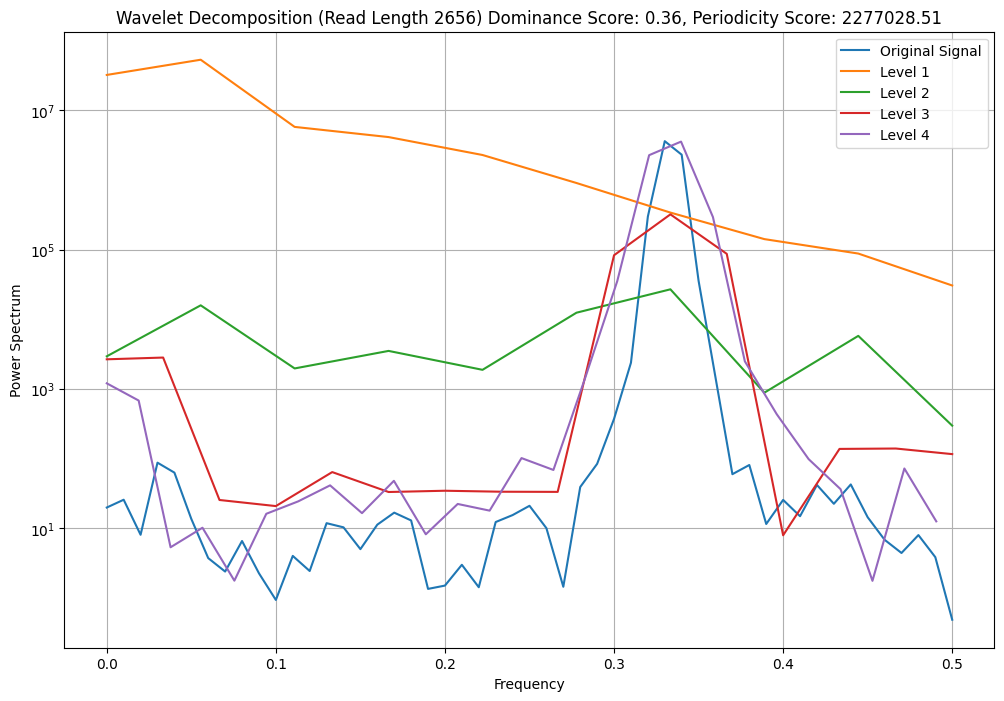

Periodicity Score: 91694204.14168443


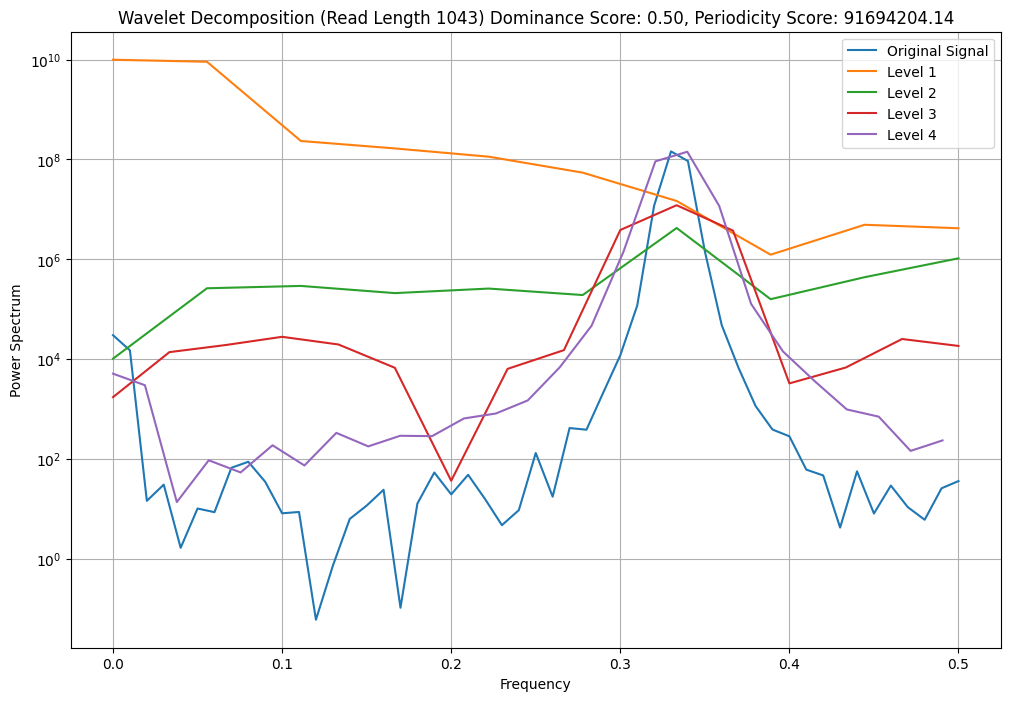

Periodicity Score: 256890810.2672492


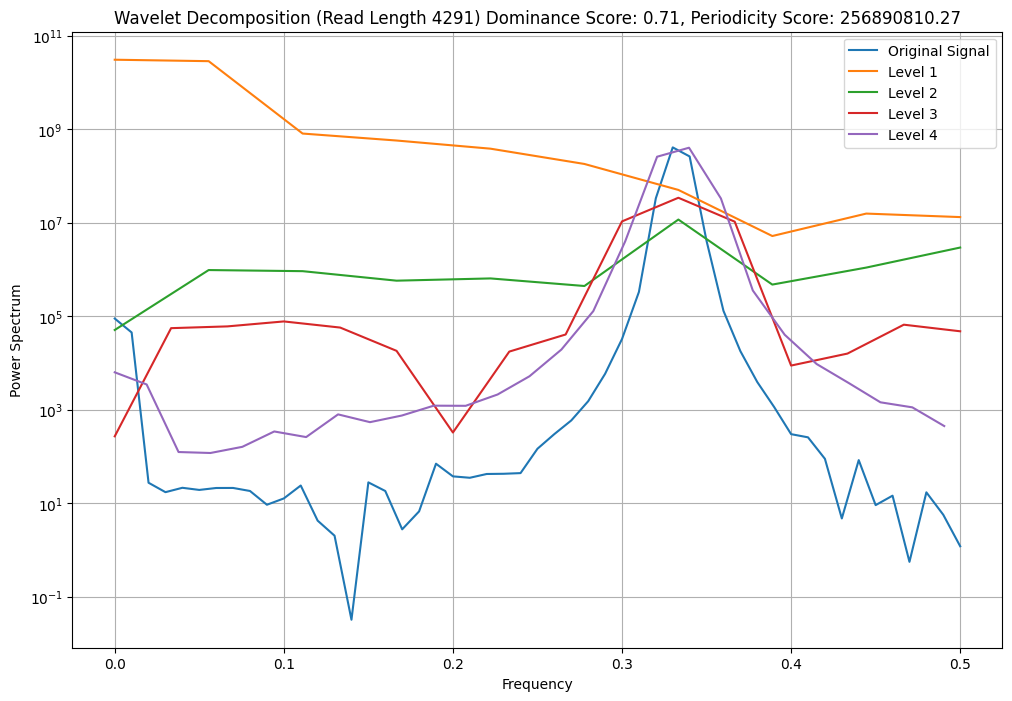

Periodicity Score: 126398339.60621575


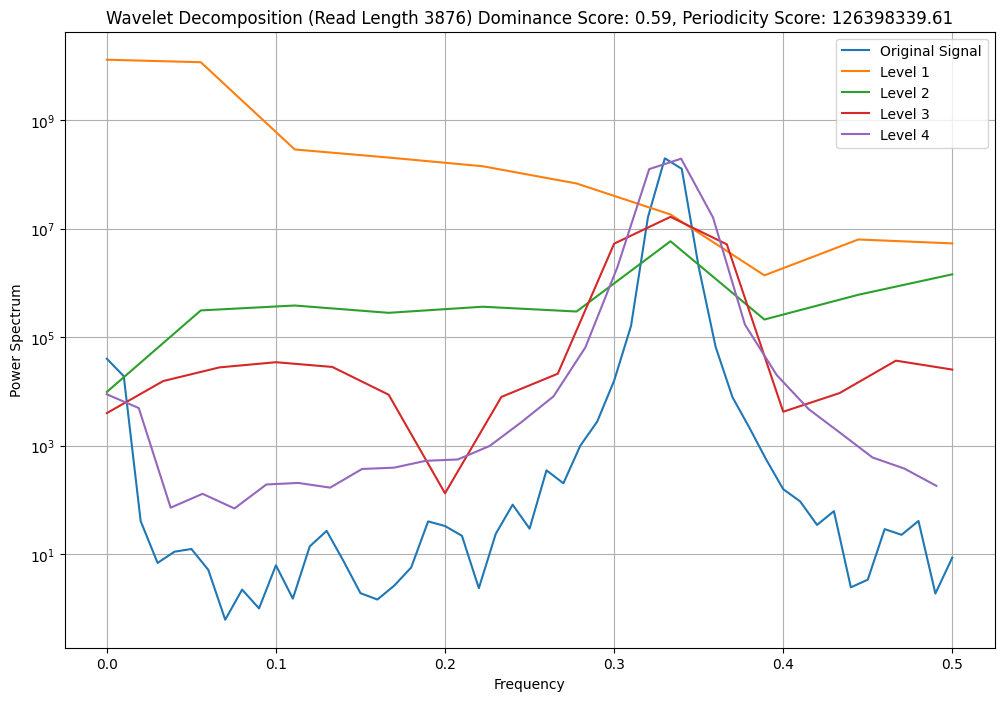

Periodicity Score: 738261747.9008691


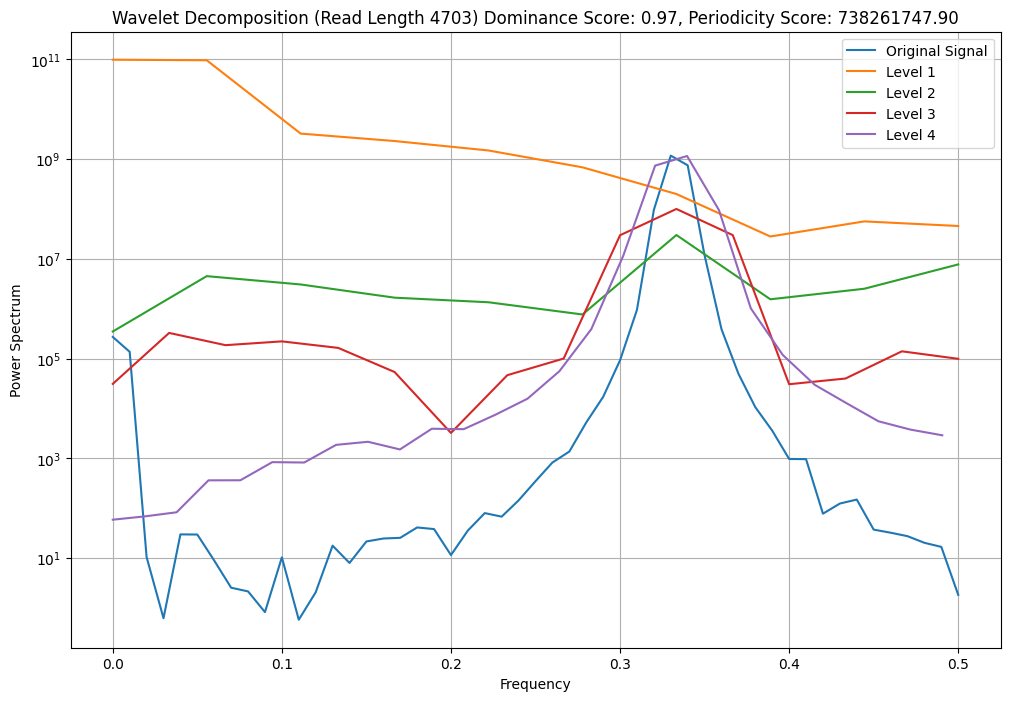

In [5]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pywt

def plot_wavelet_decomposition(metagene_profile, read_length, wavelet='db4', levels=5):
    """
    Plots the wavelet decomposition of a metagene profile for a given read length.

    Args:
        metagene_profile (dict): The metagene profile dictionary.
        read_length (int): The read length to decompose.
        wavelet (str, optional): The wavelet family to use for the DWT. Default is 'db4'.
        levels (int, optional): The number of levels to decompose the signal. Default is 5.

    Returns:
        None
    """
    counts = list(metagene_profile['start'][read_length].values())
    positions = list(metagene_profile['start'][read_length].keys())

    frame_1_counts = sum([count for i, count in enumerate(counts) if i % 3 == 0])
    frame_2_counts = sum([count for i, count in enumerate(counts) if i % 3 == 1])
    frame_3_counts = sum([count for i, count in enumerate(counts) if i % 3 == 2])
    total_counts = sum(counts)

    dominance_score = max(frame_1_counts, frame_2_counts, frame_3_counts) / total_counts

    signal_data = np.array(counts)



    # Compute wavelet decomposition
    coeffs = pywt.wavedec(signal_data, wavelet, mode='smooth', level=levels)

    periodicity_score = calculate_periodicity_score(coeffs)
    print("Periodicity Score:", periodicity_score)

    # Plot power spectrum for original signal
    f, Pxx = signal.welch(signal_data, fs=1.0, nperseg=256)  # Adjust parameters as needed
    plt.figure(figsize=(12, 8))
    plt.semilogy(f, Pxx, label='Original Signal')

    # Compute and plot power spectrum for each level
    for i in range(len(coeffs)):
        # Compute power spectrum for current level
        f, Pxx = signal.welch(coeffs[i], fs=1.0, nperseg=256)  # Adjust parameters as needed

        # Plot power spectrum of current level
        plt.semilogy(f, Pxx, label=f'Level {i + 1}')

    plt.xlabel('Frequency')
    plt.ylabel('Power Spectrum')

    title=f'Wavelet Decomposition (Read Length {read_length}) Dominance Score: {dominance_score:.2f}, Periodicity Score: {periodicity_score:.2f}'

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def calculate_periodicity_score(coeffs, target_frequency=0.33):
    """
    Calculates a periodicity score based on peaks in the power spectrum at the target frequency.

    Args:
        power_spectrum (array): Power spectrum of a signal.
        target_frequency (float): Target frequency of interest.

    Returns:
        float: Periodicity score.
    """
    # get theoretical max value
    


    power_spectrum = signal.welch(coeffs[-1], fs=1.0, nperseg=256)  # Power spectrum of Level 4 coefficients

    # Find indices of frequency closest to the target frequency
    target_idx = np.argmin(np.abs(power_spectrum[0] - target_frequency))

    # Calculate score as the amplitude of the peak at the target frequency
    score = power_spectrum[1][target_idx]

    # Normalize score
    normalized_score = score / np.max(signal.welch(coeffs[0], fs=1.0, nperseg=256) )

    return score

metagene_dominance_scores = {}
for read_len in simulated_metagenes['start']:
    frame_1_counts = sum([count for i, count in enumerate(simulated_metagenes['start'][read_len].values()) if i % 3 == 0])
    frame_2_counts = sum([count for i, count in enumerate(simulated_metagenes['start'][read_len].values()) if i % 3 == 1])
    frame_3_counts = sum([count for i, count in enumerate(simulated_metagenes['start'][read_len].values()) if i % 3 == 2])
    total_counts = sum(simulated_metagenes['start'][read_len].values())

    dominance_score = max(frame_1_counts, frame_2_counts, frame_3_counts) / total_counts
    metagene_dominance_scores[dominance_score] = read_len

# Sort metagenes by dominance score
sorted_metagenes = {k: v for k, v in sorted(metagene_dominance_scores.items(), key=lambda item: item[0])}

# Plot the metagenes with the highest and lowest dominance scores
lowest_dominance_metagene = list(sorted_metagenes.values())[10]
low_mid_dominance_metagene = list(sorted_metagenes.values())[int(len(sorted_metagenes)/4)]
high_mid_dominance_metagene = list(sorted_metagenes.values())[int(len(sorted_metagenes)*3/4)]
mid_mid_dominance_metagene = list(sorted_metagenes.values())[int(len(sorted_metagenes)/2)]
highest_dominance_metagene = list(sorted_metagenes.values())[-1]

ordered_subset_metagenes = { 'start': {
    lowest_dominance_metagene: simulated_metagenes['start'][lowest_dominance_metagene],
    low_mid_dominance_metagene: simulated_metagenes['start'][low_mid_dominance_metagene],
    high_mid_dominance_metagene: simulated_metagenes['start'][high_mid_dominance_metagene],
    mid_mid_dominance_metagene: simulated_metagenes['start'][mid_mid_dominance_metagene],
    highest_dominance_metagene: simulated_metagenes['start'][highest_dominance_metagene]
}}
for metagene in ordered_subset_metagenes['start']:
    plot_wavelet_decomposition(ordered_subset_metagenes, metagene, wavelet='sym4', levels=3)
